In [3]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt

## Progress bar
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
print("Using torch", torch.__version__)

import gym

Using torch 1.12.1+cu102


In [92]:
# each layer has a unique min weight size, std_dev, layer size and transmitter value
# to provide a diversity of transmitter values, multiple layers should be used for each layers output
class Layer:
    
    def __init__(
            self, 
            init_weight_std_dev, 
            minimum_weight_value, 
            weight_step_size,
            weight_decay_rate,
            counter_decay_rate,
            input_size, 
            layer_size, 
            transmitter_value):
                
        # store layer configs
        self.std_dev = init_weight_std_dev
        self.min_weight_value = minimum_weight_value
        self.weight_step_size = weight_step_size
        self.weight_decay_rate = weight_decay_rate
        self.counter_decay_rate = counter_decay_rate
        self.input_size = input_size
        self.layer_size = layer_size
        self.transmitter_value = transmitter_value
        
        # create initial values for neuron level values
        self.activations = torch.ones(layer_size)
        self.counters = torch.zeros(layer_size)   
        
        # create decaying fire tracking tensor
        self.fire_trackers = torch.zeros((input_size, layer_size))

        # initialize weights with std_dev passed
        self.weights = torch.zeros((input_size, layer_size))
        nn.init.normal_(self.weights, std=self.std_dev) 
                
    def eval(self, input_tensor, layer_env_reward):
        # update weights from last steps reward
        #print("Updating Weights with reward:", layer_env_reward)
        #print("weights:", self.weights)
        #print("fire_trackers:", self.fire_trackers)
        self.weights += self.fire_trackers * self.weight_step_size * layer_env_reward
        self.fire_trackers *= self.weight_decay_rate
        #print("new weights:", self.weights)

        #print("input:", input_tensor)
        activated_weights = torch.sigmoid(self.weights) 
        filtered_weight_bool = activated_weights > self.min_weight_value
        activated_weights = activated_weights * filtered_weight_bool
        #print("activated_weights:", activated_weights)
        weightwise_output = (activated_weights.transpose(0,1) * input_tensor).transpose(0,1)
        #print("weightwise_output:", weightwise_output)
        self.counters += torch.sum(weightwise_output, 0)
        #print("counters:", self.counters)
        output_bool = self.counters > self.activations
        #print("output_bool:", output_bool)
        self.fire_trackers += (torch.abs(weightwise_output) * output_bool)
        #print("fire_trackers:", self.fire_trackers)
        # maybe just set to 0? maybe never can go below 0 either?
        self.counters -= self.activations * output_bool
        self.counters *= self.counter_decay_rate
        #print("counters:", self.counters)
        output = output_bool * self.transmitter_value
        #print("output:", output)
        return output
    
    def reset(self):
        self.fire_trackers = torch.zeros((self.input_size, self.layer_size))
        self.counters = torch.zeros(self.layer_size)   
        

class Agent:
    
    def __init__(self, seed, layers):
        torch.manual_seed(seed)
        self.layers = layers
    
    def step(self, input_state):
        input_tensor = input_state

        for i, layer in enumerate(self.layers):
            layer_output = layer.eval(input_tensor)
            
        output = input_tensor
        output_fires = output >= 1
        value, action = torch.max(output, axis=0)
        action = action.item() 
        if value == 0:
            action = None
            
        print("output", output, "action", action)
        return action
    
    def reset(self):
        for layer in self.layers:
            layer.reset()


input: tensor([1, 0]) output: tensor([1, 1]) reward: -1
input: tensor([1, 0]) output: tensor([1, 1]) reward: -1
input: tensor([1, 0]) output: tensor([1, 1]) reward: -1
input: tensor([1, 0]) output: tensor([1, 1]) reward: -1
input: tensor([1, 0]) output: tensor([1, 1]) reward: -1
accuracy:  -500.0


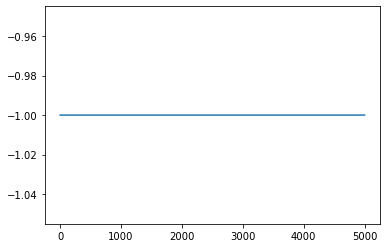

In [101]:
rewards = []
seed = 422 
torch.manual_seed(seed)
# this will make negative weights, make sure weights are positive (sigmoid?)
init_weight_std_dev = .1 
minimum_weight_value = .3
weight_step_size = .001
weight_decay_rate = 0
counter_decay_rate = .9

pos_symbol_layer = Layer(
                    init_weight_std_dev=init_weight_std_dev, 
                    minimum_weight_value=minimum_weight_value, 
                    weight_step_size=weight_step_size,
                    weight_decay_rate=weight_decay_rate,
                    counter_decay_rate=counter_decay_rate,
                    input_size=3, 
                    layer_size=10, 
                    transmitter_value=1)

neg_symbol_layer = Layer(
                    init_weight_std_dev=init_weight_std_dev, 
                    minimum_weight_value=minimum_weight_value, 
                    weight_step_size=weight_step_size,
                    weight_decay_rate=weight_decay_rate,
                    counter_decay_rate=counter_decay_rate,
                    input_size=3, 
                    layer_size=10, 
                    transmitter_value=-1)

output_layer = Layer(
                init_weight_std_dev=init_weight_std_dev, 
                minimum_weight_value=minimum_weight_value, 
                weight_step_size=weight_step_size,
                weight_decay_rate=weight_decay_rate,
                counter_decay_rate=counter_decay_rate,
                input_size=20, 
                layer_size=2, 
                transmitter_value=1)

iters = 5000

# train on xor
count = 0
for i in range(iters):
    pos_symbol_layer.reset()
    neg_symbol_layer.reset()
    output_layer.reset()
    a = np.array([1, 0])
    input_tensor = torch.from_numpy(a)
    #input_tensor = torch.randint(0, 2, (2,))
    # cat a 1 to the end of the input to act as passive control input 
    effective_input_tensor = torch.cat((input_tensor, torch.ones((1,))))
    action = None
    output_count = 0
    reward = 0
    while output_count < 10:
        pos_layer_out = pos_symbol_layer.eval(effective_input_tensor, reward)
        neg_layer_out = neg_symbol_layer.eval(effective_input_tensor, reward)
        
        concatted_symbol_outs = torch.cat((pos_layer_out, neg_layer_out))
        output = output_layer.eval(concatted_symbol_outs, reward)

        value, action = torch.max(output, axis=0)
        action = action.item() 
        if value == 0:
            action = None
        
        output_count += 1
        if action == None:
            reward = 0
        else:
            time_steps = 0
            
            input_sum = torch.sum(input_tensor)
            
            # output should be false, or index 0
            if input_sum == 0 or input_sum == 2:
                if output[0] == 1 and output[1] == 0:
                    reward = 0
                else:
                    reward = -1
            else:
                if output[0] == 0 and output[1] == 1:
                    reward = 0
                else:
                    reward = -1
                
            if i % 1000 == 0:
                print("input:", input_tensor, "output:", output, "reward:", reward)
            
            rewards.append(reward)
            break


print("accuracy: ", sum(rewards) / (output_count))
plt.cla()
plt.plot(rewards)
plt.show()